In [1]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as st
import seaborn as sns
import json
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.stats.stattools as stt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_goldfeldquandt
import statsmodels.graphics.tsaplots
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.anova import anova_lm
from statsmodels.stats import outliers_influence
from statsmodels.compat import lzip
import warnings

In [2]:
warnings.filterwarnings(action="ignore", module="sklearn", message="^internal gelsd")

###############################################################
# Linear Regression Analysis
###############################################################

def linear_regression_analysis(linear_regression):
    """ Compute and plot a complete analysis of a linear regression computed with Stats Models.
    Args:
         linear_regression (Stats Models Results): the result obtained  with Stats Models.
    """

    # Data
    resid = linear_regression.resid_pearson.copy()
    resid_index = linear_regression.resid.index
    exog = linear_regression.model.exog
    endog = linear_regression.model.endog
    fitted_values = linear_regression.fittedvalues
    influences = outliers_influence.OLSInfluence(linear_regression)

    p = exog.shape[1] # Number of features
    n = len(resid) # Number of individuals

    # Paramètres
    color1 = "#3498db"
    color2 = "#e74c3c"

    ##############################################################################
    # Tests statistiques                                                         #
    ##############################################################################

    # Homoscédasticité - Test de Breusch-Pagan
    ##########################################

    names = ['Lagrande multiplier statistic', 'p-value', 'f-value', 'f p-value']
    breusch_pagan = sm.stats.diagnostic.het_breuschpagan(resid, exog)
    print(lzip(names, breusch_pagan))

    # Test de normalité - Shapiro-Wilk
    ###################################

    print(f"Shapiro pvalue : {st.shapiro(resid)[1]}")

    ##############################################################################
    # Analyses de forme                                                          #
    ##############################################################################

    # Histogramme des résidus
    ##########################
    data = resid
    data_filter = data[data < 5]
    data_filter = data[data > -5]
    len_data = len(data)
    len_data_filter = len(data_filter)
    ratio = len_data_filter / len_data

    fig, ax = plt.subplots()
    plt.hist(data_filter, bins=20, color=color1)
    plt.xlabel("Residual values")
    plt.ylabel("Number of residuals")
    plt.title(f"Histogramme des résidus de -5 à 5 ({ratio:.2%})")

    # Normal distribution vs residuals (QQ Plot, droite de Henry)
    #############################################################
    data = pd.Series(resid).sort_values()
    len_data = len(data)

    normal = pd.Series(np.random.normal(size=len_data)).sort_values()
    fig, ax = plt.subplots()
    plt.scatter(data, normal, c=color1)
    plt.plot((-4,4), (-4, 4), c=color2)
    plt.xlabel("Residuals")
    plt.ylabel("Normal distribution")
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.title("Residuals vs Normal (QQ Plot)")

    
    # Plot
    plt.show()

# Introduction

Vous êtes employé chez Enercoop, société coopérative qui s'est développée grâce à la libéralisation du
marché de l’électricité en France. Elle est spécialisée dans les énergies renouvelables.
La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les
capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du
temps, et dépend de paramètres comme la météo (température, luminosité, etc.) Tout le challenge est de
mettre en adéquation l'offre et la demande !

# 1 - Exploration des données
## Dataset "Consommation d'électricité"

In [3]:
eco = pd.read_csv("eCO2mix_RTE_energi.csv", sep=';')
eco

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1398,2021-11,Données consolidées,Occitanie,2142,897.0,59,NaN,0,59,638,...,60,3581,-1608.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1399,2021-11,Données consolidées,Normandie,5376,4929.0,239,-1.0,31,208,5,...,58,2528,2848.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1400,2021-11,Données consolidées,Hauts-de-France,4319,2265.0,1239,0.0,5,1233,1,...,80,4593,-273.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1401,2021-11,Données consolidées,PACA,1745,NaN,847,-1.0,20,828,712,...,61,3561,-1821.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
eco['Territoire'].unique()

array(['France', 'Grand-Est', 'Nouvelle-Aquitaine',
       'Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre-Val de Loire', 'Ile-de-France', 'Occitanie', 'Normandie',
       'Hauts-de-France', 'PACA', 'Pays-de-la-Loire'], dtype=object)

In [5]:
# Je réduit le dataframe à la région "Ile-de-France" car les données DJU proviennent de la station Paris-Montsouris.
eco = eco.loc[eco['Territoire'] == 'Ile-de-France']

In [6]:
eco.columns

Index(['Mois', 'Qualité', 'Territoire', 'Production totale',
       'Production nucléaire', 'Production thermique totale',
       'Production thermique charbon', 'Production thermique fioul',
       'Production thermique gaz', 'Production hydraulique',
       'Production éolien', 'Production solaire', 'Production bioénergies',
       'Consommation totale', 'Solde exportateur', 'Echanges export',
       'Echanges import', 'Echanges avec le Royaume-Uni',
       'Echanges avec l'Espagne', 'Echanges avec l'Italie',
       'Echanges avec la Suisse', 'Echanges avec l'Allemagne et la Belgique'],
      dtype='object')

In [7]:
eco = eco[['Mois', 'Consommation totale']].copy()

In [8]:
eco['Consommation totale'].isnull().values.any()

False

In [9]:
eco["Mois"] = pd.to_datetime(eco["Mois"]) # conversion en datetime
eco.columns = ['date', 'consommation']
pd.set_option('display.max_rows', None)

In [10]:
# Suppression des lignes ne contenant pas de données avant 2014
eco = eco[~(eco['date'] < '2014-01-01')]

# Suppression des données Après 2020 car les données sont "consolidées" et pas "définitives"
eco = eco[~(eco['date'] > '2019-12-01')]
eco

,date,consommation
175,2014-01-01,7612
188,2014-02-01,6749
201,2014-03-01,6509
214,2014-04-01,5396
227,2014-05-01,5279
240,2014-06-01,4815
253,2014-07-01,4889
266,2014-08-01,4355
279,2014-09-01,4874
292,2014-10-01,5535


In [11]:
eco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 175 to 1098
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          72 non-null     datetime64[ns]
 1   consommation  72 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.7 KB


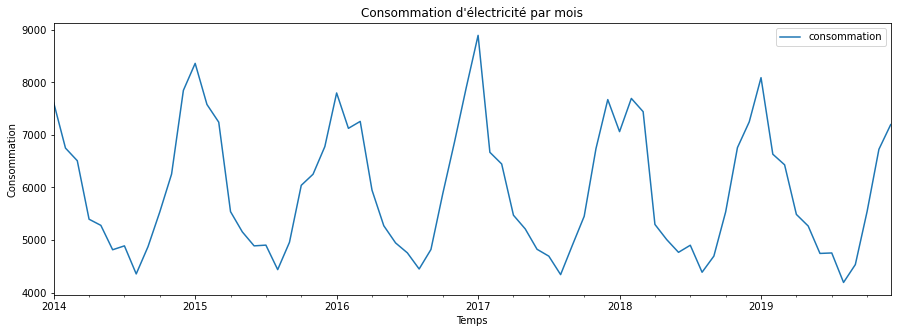

In [12]:
eco.plot(x='date', y='consommation', figsize=(15,5))
plt.xlabel('Temps')
plt.ylabel('Consommation')
plt.title('Consommation d\'électricité par mois')
plt.savefig("Consommation d'électricité par mois.png")

plt.show()

## Dataset "DJU"
"Le degré jour unifié (DJU) est la différence entre la température extérieure et une température de référence qui permet de réaliser des estimations de consommations d'énergie thermique pour maintenir un bâtiment confortable en proportion de la rigueur de l'hiver ou de la chaleur de l'été."

In [13]:
dju = pd.read_csv('calcul_DJU_16_03_2022.csv', sep=';', decimal=".")
dju

,Unnamed: 0,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
0,2021,"396,7","302,8",271,"228,3","138,3","1,4",0,0,0,0,0,0,"1338,2"
1,2020,339,"249,6","268,6","81,4","65,7","20,6","0,9","4,5","34,3","157,5","227,2","336,8","1785,9"
2,2019,"404,9","268,3","233,1","168,5","117,9","24,4",0,"1,7","26,7","133,7","282,6","327,3",1989
3,2018,"303,4","432,6","314,3","119,7","55,9","8,1",0,"3,3","34,3","122,4","282,5","325,9","2002,2"
4,2017,"467,9","278,4","206,1","182,6",75,"9,4",1,"6,8","62,6","99,4","282,6",369,"2040,6"
5,2016,"364,4","321,6","321,1","212,1","88,1","27,5","5,7","3,2","11,7",176,"285,6","390,8","2207,3"
6,2015,392,"365,7","275,5","141,1","91,5","15,8","6,9","6,1","71,9","176,9",195,"248,1","1986,2"
7,2014,"324,4","281,9","223,9","135,5","100,2","19,1","8,3","19,3",16,"92,3","222,6","368,2","1811,5"
8,2013,"429,2","402,2","376,6","209,5","158,4","43,6","0,6",5,"41,5",105,"303,9","349,5","2424,8"
9,2012,336,"435,9","201,9","230,3","83,3",35,"12,4","2,4",58,"154,6","296,2","345,9","2191,5"


In [14]:
# On supprime la colonne "total"
dju = dju.drop('Total', axis=1)

# On renomme les colonnes
dju.columns = ['annee', '01', '02', '03', '04', '05', '06', 
               '07', '08', '09', '10', '11', '12']

# On crée un colonne "mois"
dju = pd.melt(dju, id_vars='annee', var_name='mois', value_name='dju')

# On concatène les années et les mois + conversion en datetime
dju['date'] = pd.to_datetime(dju['annee']\
                                       .astype(str) + '-' + dju['mois'], 
                                                                     format='%Y-%m')
dju = dju.drop(['annee', 'mois'], axis=1)

In [15]:
dju['dju'] = dju['dju'].str.replace(',', '.').astype(float)
dju

,dju,date
0,396.7,2021-01-01
1,339.0,2020-01-01
2,404.9,2019-01-01
3,303.4,2018-01-01
4,467.9,2017-01-01
5,364.4,2016-01-01
6,392.0,2015-01-01
7,324.4,2014-01-01
8,429.2,2013-01-01
9,336.0,2012-01-01


In [16]:
dju.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dju     156 non-null    float64       
 1   date    156 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.6 KB


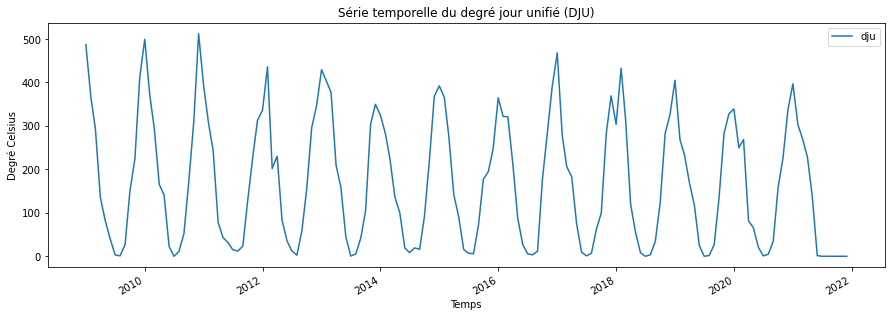

In [17]:
dju.plot(x='date', y='dju', figsize=(15,5))
plt.xlabel('Temps')
plt.ylabel('Degré Celsius')
plt.title('Série temporelle du degré jour unifié (DJU)')
plt.savefig("DJU par mois.png")
plt.show()

## Fusion des datasets

In [18]:
df = pd.merge(dju, eco, how='inner')
df = df.set_index('date').sort_index()

In [19]:
pd.set_option('display.max_rows', None)
print(df)

              dju  consommation
date                           
2014-01-01  324.4          7612
2014-02-01  281.9          6749
2014-03-01  223.9          6509
2014-04-01  135.5          5396
2014-05-01  100.2          5279
2014-06-01   19.1          4815
2014-07-01    8.3          4889
2014-08-01   19.3          4355
2014-09-01   16.0          4874
2014-10-01   92.3          5535
2014-11-01  222.6          6255
2014-12-01  368.2          7847
2015-01-01  392.0          8361
2015-02-01  365.7          7579
2015-03-01  275.5          7242
2015-04-01  141.1          5540
2015-05-01   91.5          5155
2015-06-01   15.8          4889
2015-07-01    6.9          4903
2015-08-01    6.1          4437
2015-09-01   71.9          4957
2015-10-01  176.9          6041
2015-11-01  195.0          6252
2015-12-01  248.1          6778
2016-01-01  364.4          7798
2016-02-01  321.6          7125
2016-03-01  321.1          7257
2016-04-01  212.1          5950
2016-05-01   88.1          5272
2016-06-

In [20]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dju           72 non-null     float64
 1   consommation  72 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 1.7 KB


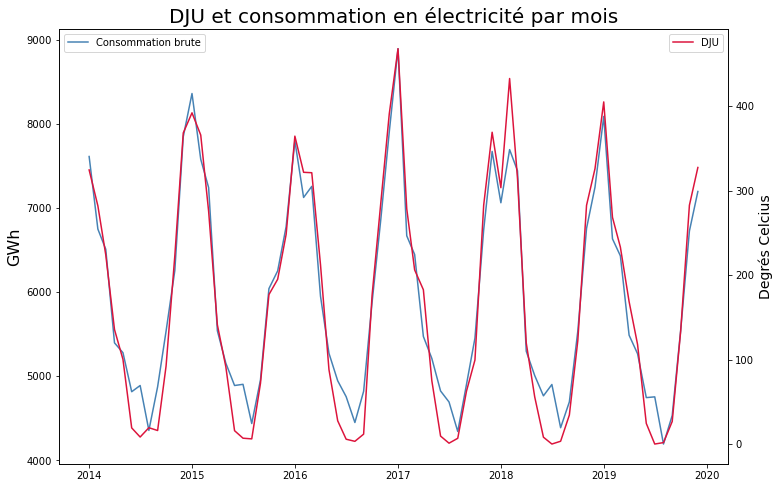

In [21]:
plt.figure(figsize=(12,8))
plt.plot(df["consommation"], label="Consommation brute", color="steelblue")
plt.ylabel("GWh", fontsize=16), plt.legend(loc="upper left")

ax2 = plt.gca().twinx() ; plt.plot(df["dju"], label="DJU", color="crimson")
plt.title("DJU et consommation en électricité par mois", fontsize=20), plt.ylabel("Degrés Celcius", fontsize=14), plt.legend()
plt.savefig("DJU et consommation en électricité par mois.png")
plt.show()

On peut déjà constater que les deux variables ont une même silhouette sur l'ensemble de la série.

# 2 - Analyse des données
## 2.a - Répartition des variables
### Consommation électrique

<Figure size 1440x1440 with 0 Axes>

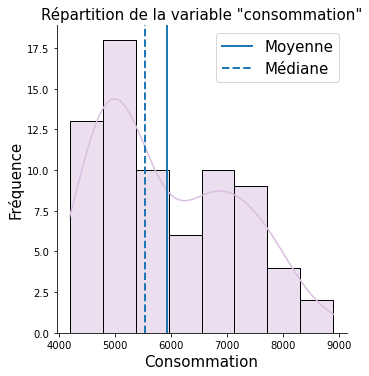

In [22]:
plt.figure(figsize = (20,20))

sns.displot(df["consommation"],
                     kde=True,
                  color='#D9BFE0')

plt.axvline(x=df["consommation"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=df["consommation"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('Consommation', size=15)
plt.ylabel('Fréquence', size=15)
plt.title('Répartition de la variable "consommation"', size=15)
plt.legend(prop={'size':15})
plt.savefig("Répartition de la variable consommation d'électricité.png")
plt.show();

In [23]:
st.shapiro(df['consommation'])

ShapiroResult(statistic=0.9275088906288147, pvalue=0.0004707935731858015)

Test de shapiro-wilk, le plus intéressant pour les petits effectifs, pour vérifier que la distribution est normale avec comme hypothèses :
- H0 : probable que la distribution ne soit pas normale
- H1 : probable que la distribution soit normale

La pvalue étant inférieure à 0,05, on peut rejeter H0. La distribution est probablement normale.

### DJU

<Figure size 1440x1440 with 0 Axes>

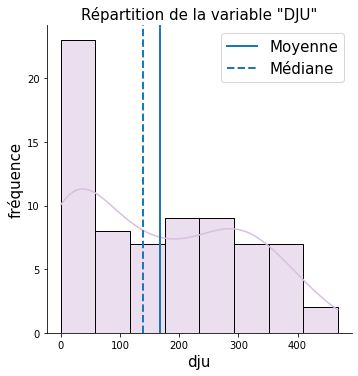

In [24]:
plt.figure(figsize = (20,20))

sns.displot(df["dju"],
                     kde=True,
                  color='#D9BFE0')

plt.axvline(x=df["dju"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=df["dju"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('dju', size=15)
plt.ylabel('fréquence', size=15)
plt.title('Répartition de la variable "DJU"', size=15)
plt.savefig("répartition du DJU.png")
plt.savefig("Répartition de la variable DJU.png")
plt.legend(prop={'size':15})
plt.show();

In [25]:
st.shapiro(df['dju'])

ShapiroResult(statistic=0.9094897508621216, pvalue=7.503310916945338e-05)

Test de shapiro-wilk, le plus intéressant pour les petits effectifs, pour vérifier que la distribution est normale avec comme hypothèses :
- H0 : probable que la distribution ne soit pas normale
- H1 : probable que la distribution soit normale

La pvalue étant inférieure à 0,05, on peut rejeter H0. La distribution est probablement normale.

## 2.b - Régression linéaire
Les deux variables ayant une distribution normale, on peut effectuer une régression linéaire.

C:\Users\maxim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


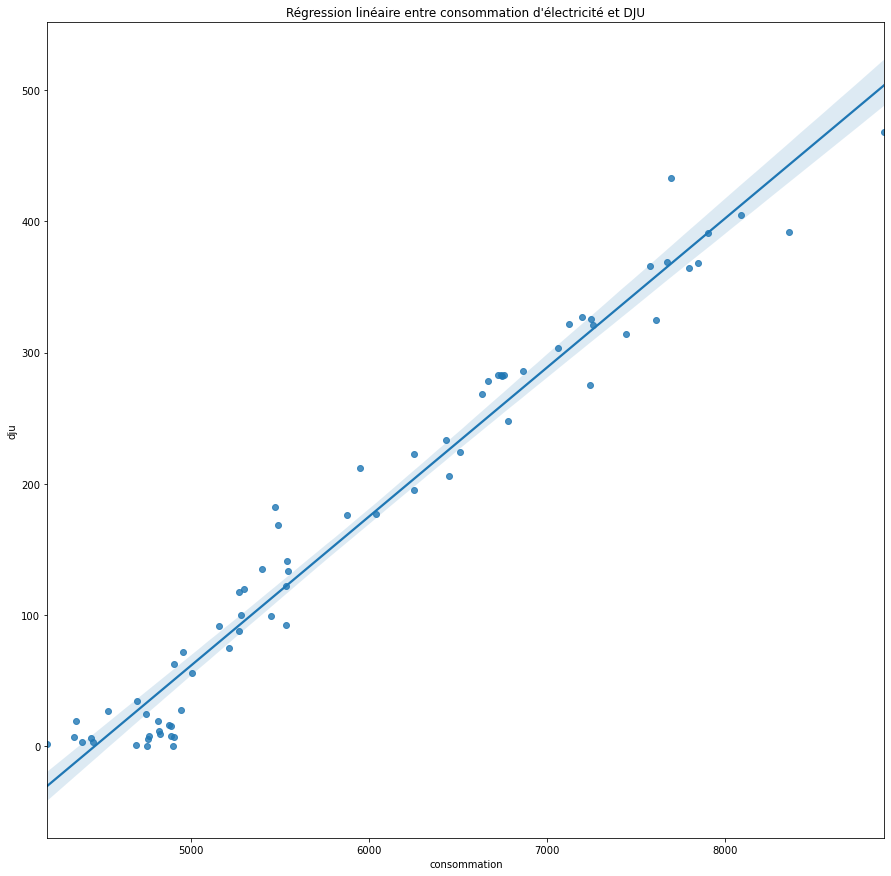

In [26]:
plt.figure(figsize=(15,15))
sns.regplot('consommation', 'dju', data=df)
plt.title('Régression linéaire entre consommation d\'électricité et DJU')
plt.savefig("Régression linéaire entre consommation d'électricité et DJU.png")
plt.show();

In [27]:
# On enregistre les paramètres de la régression linéaire
x = sm.add_constant(df['dju'])
y = df['consommation']

reg = sm.OLS(y, x).fit()
params = reg.params['dju']

In [28]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           consommation   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1896.
Date:                Mon, 04 Apr 2022   Prob (F-statistic):           1.93e-52
Time:                        08:01:10   Log-Likelihood:                -492.30
No. Observations:                  72   AIC:                             988.6
Df Residuals:                      70   BIC:                             993.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4510.0898     42.312    106.591      0.0

Le R-carré est une mesure statistique de la proximité des données à la droite de régression ajustée, c’est le pourcentage de variation de la variable de réponse qui est expliqué par un modèle linéaire : 
- 0% indique que le modèle n’explique aucune de la variabilité des données de réponse autour de sa moyenne.
- 100% indique que le modèle explique toute la variabilité des données de réponse autour de sa moyenne.

Avec un R-carré de 0,94, il y a une forte corrélation entre consommation électrique et DJU.

P-value = 0
- H0 = pas de corrélation
- pvalue < 0,05 =  rejete H0
- il y a une relation entre les deux variables

In [29]:
# H0 : résidus ne suivent pas une loi normale 
# p-value < 0,05 = rejette H0
shapiro(reg.resid)

ShapiroResult(statistic=0.9863569736480713, pvalue=0.6294990181922913)

[('Lagrande multiplier statistic', 1.0866885914009874), ('p-value', 0.29720607628339313), ('f-value', 1.0726928398501665), ('f p-value', 0.3039027493444331)]
Shapiro pvalue : 0.6294990181922913


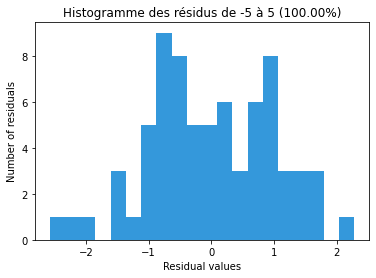

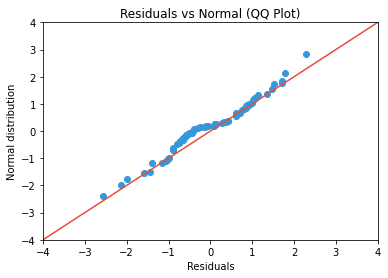

<Figure size 432x288 with 0 Axes>

In [30]:
linear_regression_analysis(reg)
plt.savefig("Résidus régression linéaire.png")

Cette régression linéaire pourrait permettre de prédire la consommation d'électricité, mais elle donne autant de poids à toutes les observations et les saisonnalités ne sont pas respectées.

## 2.c - Correction des données de l'effet température

In [31]:
# Création d'une colonne de la consommation corrigée des variables saisonnière
df['consommation corrigée'] = df['consommation'] - (df['dju'] * params)
df['consommation corrigée'] = df['consommation corrigée'].apply(lambda x : int(x))
df

,dju,consommation,consommation corrigée
date,,,
2014-01-01,324.4,7612,4856
2014-02-01,281.9,6749,4354
2014-03-01,223.9,6509,4607
2014-04-01,135.5,5396,4245
2014-05-01,100.2,5279,4427
2014-06-01,19.1,4815,4652
2014-07-01,8.3,4889,4818
2014-08-01,19.3,4355,4191
2014-09-01,16.0,4874,4738


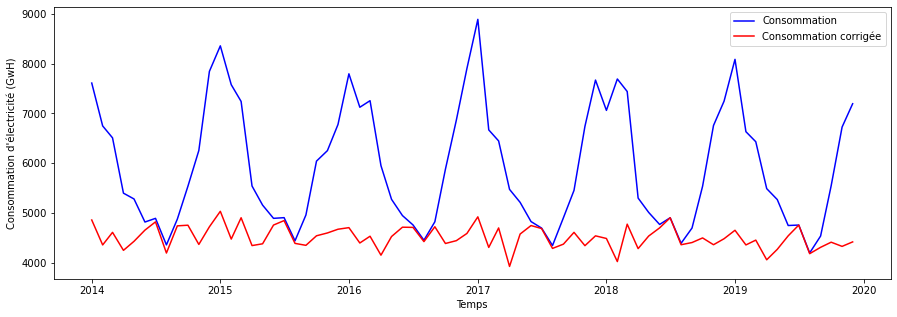

In [32]:
plt.figure(figsize=(15,5))
plt.plot(df['consommation'], label='Consommation', color='blue')
plt.plot(df['consommation corrigée'], label='Consommation corrigée', color='red')
plt.xlabel('Temps')
plt.ylabel('Consommation d\'électricité (GwH)')
plt.savefig("Consommation d'électricité et consommation d'électricité corrigée par mois.png")
plt.legend(loc='best')
plt.show()

La consommation d'électricité est maintenant corrigée de l'effet des températures (/du DJU).

## 2.d - Désaisonnalisation de la consommation grâce aux moyennes mobiles

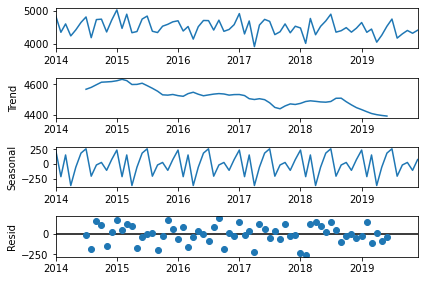

In [33]:
df_decomp = df[['consommation corrigée']]
decomp_x = seasonal_decompose(df_decomp,  model='additive', period=12)
decomp_x.plot()
plt.savefig("Décomposition de la série chronologique.png")
plt.show()

In [34]:
df['saisonnalité'] = decomp_x.seasonal #création des saisonnalités
df['consommation désaisonnalisée'] = df['consommation corrigée'] - df['saisonnalité'] #Soustraction des saisonnalités
df

,dju,consommation,consommation corrigée,saisonnalité,consommation désaisonnalisée
date,,,,,
2014-01-01,324.4,7612,4856,237.483333,4618.516667
2014-02-01,281.9,6749,4354,-210.475000,4564.475000
2014-03-01,223.9,6509,4607,154.633333,4452.366667
2014-04-01,135.5,5396,4245,-359.716667,4604.716667
2014-05-01,100.2,5279,4427,-51.341667,4478.341667
2014-06-01,19.1,4815,4652,185.916667,4466.083333
2014-07-01,8.3,4889,4818,258.641667,4559.358333
2014-08-01,19.3,4355,4191,-202.633333,4393.633333
2014-09-01,16.0,4874,4738,-13.933333,4751.933333


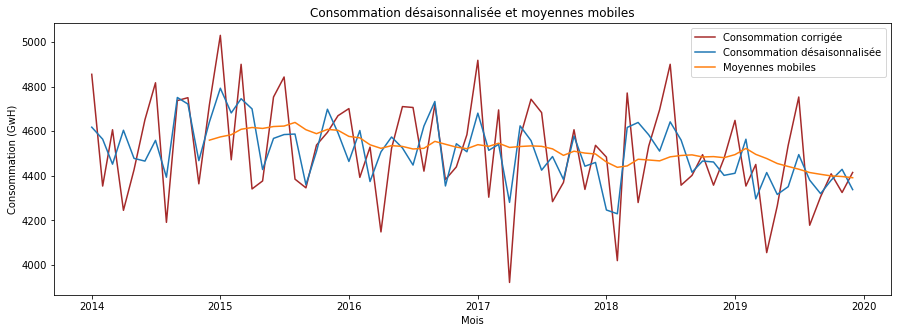

In [35]:
window_size = 12
windows = df['consommation désaisonnalisée'].rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
without_nans = moving_averages_list[window_size - 1:]

plt.figure(figsize=(15,5))
plt.plot(df['consommation corrigée'], color='brown', label='Consommation corrigée')
plt.plot(df['consommation désaisonnalisée'], label='Consommation désaisonnalisée')
plt.plot(moving_averages, label='Moyennes mobiles')
plt.xlabel('Mois')
plt.ylabel('Consommation (GwH)')
plt.title('Consommation désaisonnalisée et moyennes mobiles')
plt.savefig("Consommation désaisonnalisée et moyennes mobiles.png")
plt.legend(loc='best')
plt.show()

In [36]:
moving_averages

date
2014-01-01            NaN
2014-02-01            NaN
2014-03-01            NaN
2014-04-01            NaN
2014-05-01            NaN
2014-06-01            NaN
2014-07-01            NaN
2014-08-01            NaN
2014-09-01            NaN
2014-10-01            NaN
2014-11-01            NaN
2014-12-01    4560.166667
2015-01-01    4574.750000
2015-02-01    4584.583333
2015-03-01    4609.083333
2015-04-01    4617.083333
2015-05-01    4612.916667
2015-06-01    4621.416667
2015-07-01    4623.583333
2015-08-01    4639.750000
2015-09-01    4607.083333
2015-10-01    4589.333333
2015-11-01    4608.583333
2015-12-01    4604.500000
2016-01-01    4577.083333
2016-02-01    4570.500000
2016-03-01    4539.500000
2016-04-01    4523.416667
2016-05-01    4535.583333
2016-06-01    4532.000000
2016-07-01    4520.583333
2016-08-01    4523.583333
2016-09-01    4554.750000
2016-10-01    4541.833333
2016-11-01    4528.916667
2016-12-01    4521.833333
2017-01-01    4539.916667
2017-02-01    4532.500000
2017-03

In [37]:
# Test adfull (Augmented Dickey-Fuller)
# H0 = la série n'est pas stationnaire
# p-value > 0,05 = on accepte H0
adfuller(df['consommation corrigée'])[1] 

0.8613895042659498

In [38]:
# Test adfull (Augmented Dickey-Fuller)
# H0 = la série n'est pas stationnaire
# p-value > 0,05 = on accepte H0
adfuller(df['consommation désaisonnalisée'])[1] 

6.02789912355976e-08

Le processus de la série est, en effet, davantage stationnaire.

## 3 - Prédiction de la consommation sur un an
### 3.a - Méthode de Holt-Winters (lissage exponentiel)

Cette méthode permet de prendre en compte les tendances et les saisonnalités.

C:\Users\maxim\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


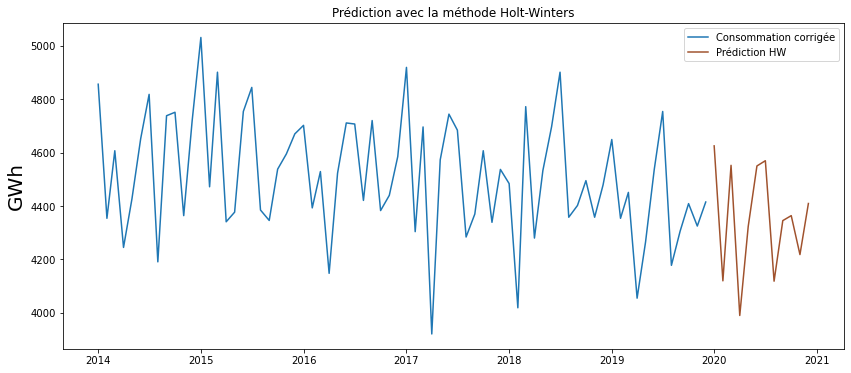

In [39]:
# On fixe les paramètres
duree_predite = 12
y = df['consommation corrigée']

# Création du modèle
hw1_model = ExponentialSmoothing(np.asarray(y), seasonal_periods=12, trend='add', seasonal='add', initialization_method='estimated', use_boxcox=True).fit()

# Prédiction
hw1_pred = hw1_model.forecast(duree_predite)

# On ajoute en index les dates correspondantes aux prédictions
hw1_pred = pd.Series(hw1_pred, index = pd.date_range(y.index.max(), periods=duree_predite, freq='M'))

plt.figure(figsize=(14,6))
plt.plot(df['consommation corrigée'], label="Consommation corrigée")
plt.plot(hw1_pred, color='sienna', label='Prédiction HW')
plt.title('Prédiction avec la méthode Holt-Winters')
plt.ylabel("GWh", fontsize=20)
plt.savefig("Prédiction 2020 avec la méthode Holt-Winters.png")
plt.legend();

C:\Users\maxim\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


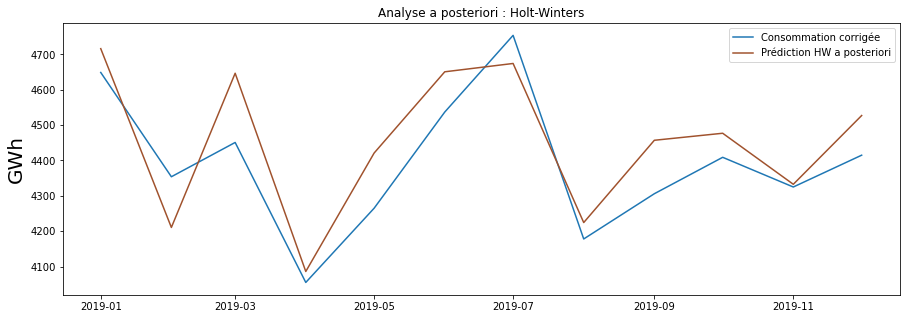

In [40]:
# Analyse a posteriori
split = duree_predite
y_troncature = y[:-split]
y_a_prevoir = y[-split:]

# creation du modèle
hw2_model = ExponentialSmoothing(np.asarray(y_troncature), seasonal_periods=12, trend='add', seasonal='add', initialization_method='estimated', use_boxcox=True).fit()

# prédiction
hw2_pred = hw2_model.forecast(duree_predite)
# on ajoute en index les dates correspondantes aux prédictions
hw2_pred = pd.Series(hw2_pred, index = y_a_prevoir.index)

# afficher les n derniers mois
nb_mois = 12

plt.figure(figsize=(15,5))

plt.plot(y[-nb_mois:], label="Consommation corrigée")
plt.plot(hw2_pred.iloc[-nb_mois:], color='sienna', label='Prédiction HW a posteriori')
plt.title('Analyse a posteriori : Holt-Winters')
plt.ylabel("GWh", fontsize=20)
plt.savefig("Analyse a posteriori Holt-Winters.png")
plt.legend();

In [41]:
y_pred = hw2_pred
y_true = np.asarray(df['consommation corrigée'].iloc[-12:])

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAE = ', mae)
print('MSE = ', mse)
print('RMSE = ', rmse)
print('MAPE = ', mape, '%')

MAE =  97.72666861094406
MSE =  12531.307304931217
RMSE =  111.94332184159633
MAPE =  2.2196580729934223 %


Le modèle semble très précis avec une marge d'erreur (MAPE) de 2,2 %.

### 3.b - Méthode Sarima

Les modèles ARIMA (AutoRegressive Integrated Moving Average) offrent une approche complémentaire de la prévision de séries chronologiques. Alors que les modèles de triple lissage exponentiel sont basés sur une description de la tendance et de la saisonnalité dans les données, les modèles ARIMA visent à décrire les autocorrélations dans les données.

Une ARIMA capture donc une suite de différentes structures temporelles. Il s’agit d’une généralisation de la moyenne mobile auto-régressive à laquelle s’ajoute un processus de différenciation afin de rendre la série temporelle stationnaire. La différenciation se calcule par différences entre les observations consécutives.

3 parties au modèle : 
- Partie autoregressive : prendra en compte les occurrences passées de la série temporelle du modèle.
- Partie intégrée : degré nécessaire pour rendre une série temporelle stationnaire, i.e. le nombre de différenciation nécessaire à appliquer sur la série chronologique.
- Moyennes mobiles : la partie à moyenne mobile utilise les erreurs de prévision passées dans un modèle de type régression.

Un modèle ARIMA saisonnier (SARIMA) est formé en incluant des termes saisonniers supplémentaires dans l'ARIMA. La partie saisonnière du modèle se compose de termes qui sont très similaires aux composantes non saisonnières du modèle, mais qui impliquent des rétrogradations de la période saisonnière.

In [42]:
# Recherche des meilleurs paramètres (le modèle avec le critère d'information AIC le plus faible)
stepwise_model=auto_arima(df['consommation corrigée'], m=12, D=1, seasonal=True, trace=True, error_action="ignore", 
                          suppress_warnings=True, stepwise=True, information_criterion="aic")
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=804.687, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=790.755, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=804.526, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=805.686, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=787.057, Time=0.57 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=785.089, Time=0.42 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=788.778, Time=0.15 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=787.049, Time=0.53 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=789.087, Time=

In [43]:
SAR=SARIMAX(np.asarray(df['consommation corrigée']), order=(0,0,0), seasonal_order=(2,1,0,12)).fit()
print(SAR.summary());

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   72
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                -392.090
Date:                  Mon, 04 Apr 2022   AIC                            790.179
Time:                          08:01:19   BIC                            796.462
Sample:                               0   HQIC                           792.637
                                   - 72                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6393      0.141     -4.523      0.000      -0.916      -0.362
ar.S.L24      -0.2629      0.141     -1.866      0.062      -0.539       0.013
sigma2      2.338e+04   4625.282    

In [44]:
SAR=SARIMAX(np.asarray(df['consommation corrigée']), order=(0,0,0), seasonal_order=(2,1,0,12)).fit()
print(SAR.summary());

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   72
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                -392.090
Date:                  Mon, 04 Apr 2022   AIC                            790.179
Time:                          08:01:19   BIC                            796.462
Sample:                               0   HQIC                           792.637
                                   - 72                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6393      0.141     -4.523      0.000      -0.916      -0.362
ar.S.L24      -0.2629      0.141     -1.866      0.062      -0.539       0.013
sigma2      2.338e+04   4625.282    

Test Ljung-Box de blancheur:
- H0 = les erreurs sont du bruit blanc
- p-value < 0,05 = rejette  H0

Heteroskedasticity
- H0 = les résidus montrent de la variance
- p-value < 0,05 = rejette H0

Jarque-Bera :
- H0 = les données sont normalement distribuées
- p-value < 0,05 = rejette H0

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6520      0.199     -3.269      0.001      -1.043      -0.261
ar.S.L24      -0.2274      0.180     -1.267      0.205      -0.579       0.124
sigma2      2.424e+04   6182.720      3.920      0.000    1.21e+04    3.64e+04


C:\Users\maxim\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\maxim\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


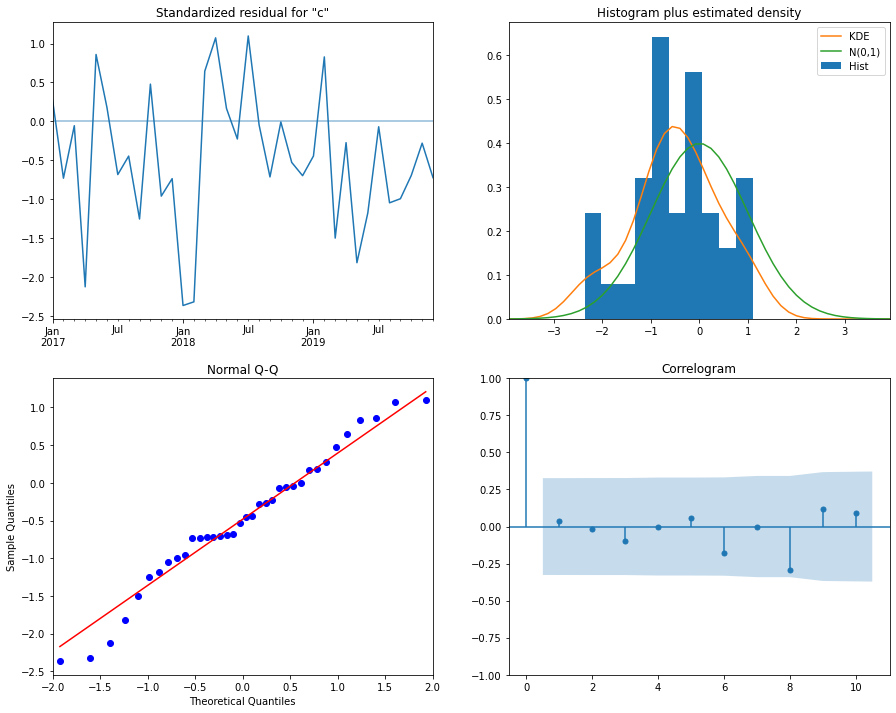

In [45]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0,0,0),
                                seasonal_order=(2,1,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.savefig("résultats sarimax.png")
plt.show();

In [46]:
# H0 : résidus ne suivent pas une loi normale 
# p-value < 0,05 = rejette H0
st.shapiro(results.resid)

ShapiroResult(statistic=0.7126473188400269, pvalue=1.4205339682327178e-10)

In [47]:
duree_predite = 12
split = duree_predite
y_troncature = y[:-split]
y_a_prevoir = y[-split:]

In [48]:
# Création du modèle
sarima_pred = SAR.get_forecast(duree_predite)

# Dataframe contenant la valeur et l'intervalle de confiance
prediction = pd.DataFrame(
               {'prediction': sarima_pred.predicted_mean,
                'conf_inf': [val[0] for val in sarima_pred.conf_int(alpha=0.05)],
                'conf_sup': [val[1] for val in sarima_pred.conf_int(alpha=0.05)]
               }, 
               index= pd.date_range(y.index.max(), periods=duree_predite, freq='M'))

Text(0.5, 1.0, 'Prédiction SARIMA 2020')

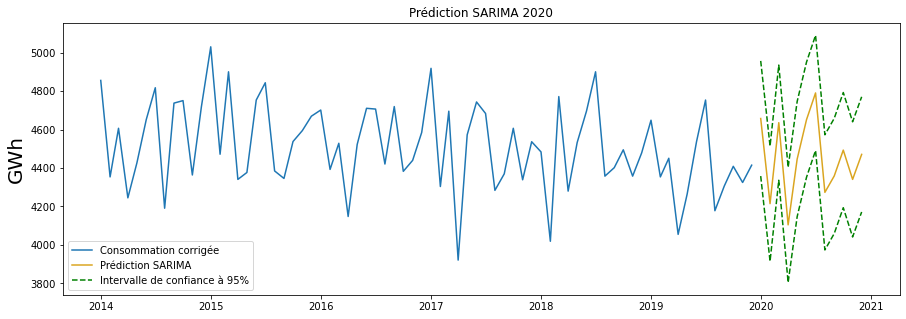

In [49]:
# Affichage de la prédiction
plt.figure(figsize=(15,5))
plt.plot(y, label="Consommation corrigée")
plt.plot(prediction['prediction'], color='goldenrod', label='Prédiction SARIMA')
plt.plot(prediction['conf_sup'], label='Intervalle de confiance à 95%', color='g', linestyle='--')
plt.plot(prediction['conf_inf'], label='', color='g', linestyle='--')
plt.ylabel("GWh", fontsize=20)
plt.savefig("Prédiction SARIMA 2020.png")
plt.legend()
plt.title('Prédiction SARIMA 2020')

In [50]:
prediction

,prediction,conf_inf,conf_sup
2019-12-31,4657.884742,4358.202741,4957.566743
2020-01-31,4214.776257,3915.094256,4514.458258
2020-02-29,4636.220432,4336.538431,4935.902433
2020-03-31,4104.451023,3804.769022,4404.133025
2020-04-30,4446.836401,4147.154400,4746.518402
2020-05-31,4651.637154,4351.955153,4951.319155
2020-06-30,4790.921034,4491.239033,5090.603035
2020-07-31,4273.611263,3973.929262,4573.293264
2020-08-31,4358.955666,4059.273665,4658.637667
2020-09-30,4493.420826,4193.738825,4793.102827


### 3.c - Prédiction a posteriori SARIMA

Text(0.5, 1.0, 'Analyse a posteriori SARIMA')

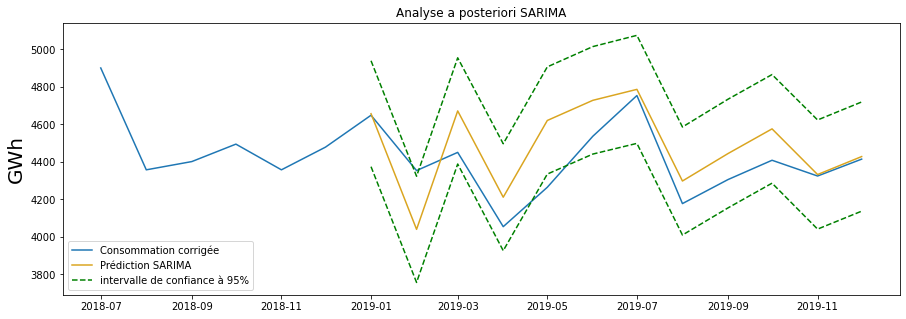

In [51]:
# Création du modèle
sarima2_model = SARIMAX(np.asarray(y_troncature), 
                        order=(3,0,2), 
                        seasonal_order=(2,1,0,12), 
                        enforce_invertibility=False, 
                        enforce_stationarity=False)

sarima2_res = sarima2_model.fit()

# Prédiction
sarima2_pred = sarima2_res.get_forecast(duree_predite)

# Création du df contenant la valeur et l'intervalle de confiance
sarima2_pred = pd.DataFrame(
               {'prediction': sarima2_pred.predicted_mean,
                'conf_inf': [val[0] for val in sarima2_pred.conf_int(alpha=0.05)],
                'conf_sup': [val[1] for val in sarima2_pred.conf_int(alpha=0.05)]
               }, 
               index= y_a_prevoir.index)

# Affichage des derniers mois
nb_mois = 18

plt.figure(figsize=(15,5))

plt.plot(y[-nb_mois:], label="Consommation corrigée")

plt.plot(sarima2_pred.iloc[-nb_mois:]['prediction'], color='goldenrod', label='Prédiction SARIMA')
plt.plot(sarima2_pred.iloc[-nb_mois:]['conf_inf'], label='intervalle de confiance à 95%', color='g', linestyle='--')
plt.plot(sarima2_pred.iloc[-nb_mois:]['conf_sup'], label='', color='g', linestyle='--')
plt.ylabel("GWh", fontsize=20)
plt.legend()
plt.savefig("Analyse a posteriori SARIMA.png")
plt.title('Analyse a posteriori SARIMA')

In [52]:
y_pred = sarima2_pred['prediction']
y_true = np.asarray(df['consommation corrigée'].iloc[-12:])

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAE = ', mae)
print('MSE = ', mse)
print('RMSE =', rmse)
print('MAPE = ', mape, '%')

MAE =  143.99456981561892
MSE =  33187.81588459714
RMSE = 182.1752340045077
MAPE =  3.3216713478462925 %


### 3.d - Comparaison des prédictions HW et SARIMA

In [53]:
# Création du modèle
hw2_model = ExponentialSmoothing(np.asarray(y_troncature), seasonal_periods=12, trend='add', seasonal='add', initialization_method='estimated', use_boxcox=True).fit()

# Prédiction
hw2_pred = hw2_model.forecast(duree_predite)

# On ajoute en index les dates correspondantes aux prédictions
hw2_pred = pd.Series(hw2_pred, index = y_a_prevoir.index)

C:\Users\maxim\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [54]:
z = df['consommation corrigée'].copy()
z_troncature = z[:-split]
z_a_prevoir = z[-split:]

(Text(0.5, 1.0, 'Comparaison des analyses a posteriori HW et SARIMA'),
 Text(98.5, 0.5, 'GWh'),
 <matplotlib.legend.Legend at 0x1eadfa09130>)

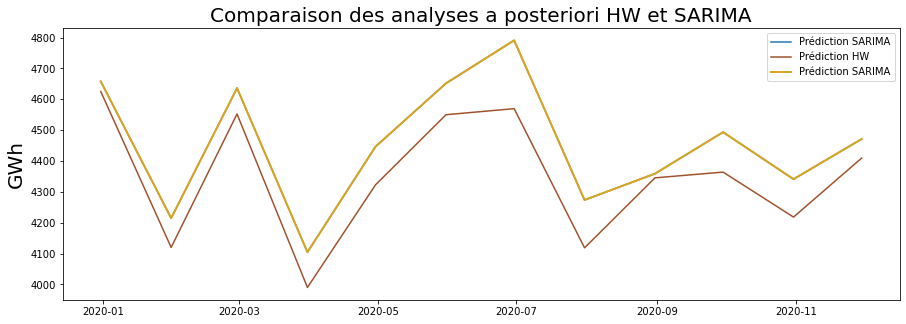

In [55]:
plt.figure(figsize=(15, 5))

plt.plot(prediction['prediction'], label="Prédiction SARIMA")
plt.plot(hw1_pred, color='sienna', label='Prédiction HW')
plt.plot(prediction['prediction'], color="goldenrod", label="Prédiction SARIMA", linewidth=2)
plt.savefig("Comparaison des prévisions HW et SARIMA.png")
plt.title("Comparaison des analyses a posteriori HW et SARIMA", fontsize=20), plt.ylabel("GWh", fontsize=20), plt.legend()

(Text(0.5, 1.0, 'Comparaison des prédictions HW et SARIMA'),
 Text(98.5, 0.5, 'GWh'),
 <matplotlib.legend.Legend at 0x1eadfa4bdc0>)

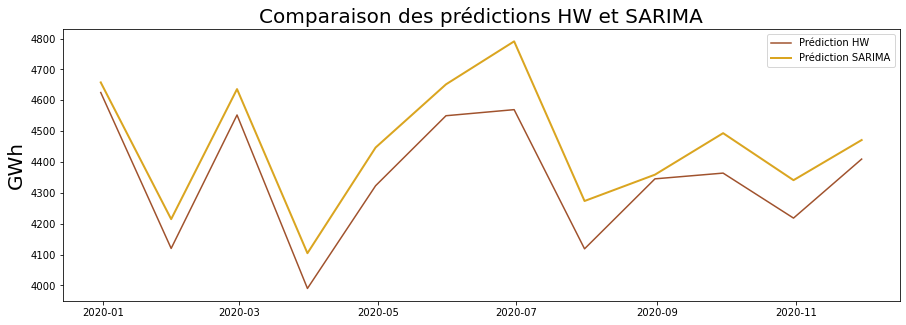

In [56]:
plt.figure(figsize=(15, 5))

plt.plot(hw1_pred, color='sienna', label='Prédiction HW')
plt.plot(prediction['prediction'], color='goldenrod', label='Prédiction SARIMA', linewidth=2)
plt.savefig("Comparaison des prévisions HW et SARIMA.png")
plt.title("Comparaison des prédictions HW et SARIMA", fontsize=20), plt.ylabel("GWh", fontsize=20), plt.legend()

# 4 - Conclusions

La prédiction SARIMA a un taux d'erreur légèrement supérieur. 

Il convient donc de retenir la méthode Holt Winters pour prédire la consommation et adapter la production d'électricité d'Enercoop.